In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from IPython import display
from scipy.signal import convolve2d
from math import *
from tqdm import tqdm
import time
import sys
plt.rcParams['figure.figsize'] = [7, 7]

def load_image(filename):
    img = np.asarray(Image.open(filename))
    img = img.astype("float32") / 255.
    return img

def gray2rgb(image):
    return np.repeat(np.expand_dims(image, 2), 3, axis=2)

def show_image(img):
    if len(img.shape) == 2:
        img = gray2rgb(img)
    plt.imshow(img, interpolation='nearest')

Visualizing Stereo Pairs
------------------------

Let's visualize the images captured by the left and right camera pair. These images from the Middlebury Stereo Dataset (http://vision.middlebury.edu/stereo/data/). 

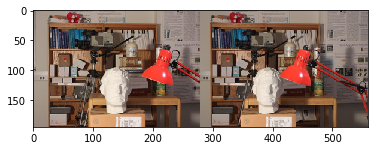

In [2]:
left = load_image('im0.jpg')
right = load_image('im1.jpg')

height,width,_ = left.shape

pad_size = 100

left_pad = np.pad(left, ((pad_size, pad_size), (pad_size, pad_size), (0,0)), mode='constant')
right_pad = np.pad(right, ((pad_size, pad_size), (pad_size, pad_size), (0,0)), mode='constant')

show_image(np.concatenate([left, right], axis=1))


Problem 1: Greedy Stereo Matching (50 points)
---------------------------------------------

From the left and right image, calculate the disparity between each pixel using a greedy matching algorithm. You may assume that the stereo pairs are rectified, which means the camera pairs are only horizontally translated. In your PDF, be sure to include both the code and the visualization of the estimated disparity. 

**Distance Function**: There are a variety of distance functions that you can use. For this problem, you can just use sum of squared differences between RGB patches.

**Accuracy**: It is very hard to get the right result with a greedy approach. However, your approach should at least put the head and background in right place. 

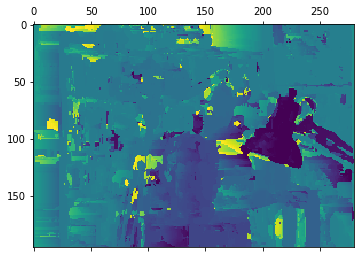

In [3]:
# Some variables that might help you. But you don't have to use them.
# default value win_size = 5
# default max_dx = 30

max_dx = 50 # max number of displacements to search. make this smaller to speed up
dxs = np.linspace(-max_dx, max_dx, num=2*max_dx+1).astype("int32")
win_size = 2 # size of window you use for ssd computation

def compute_disparity():
    # TODO: calculate the disparity using a greedy approach between left and right
    disparity = np.zeros((height,width))
    
    height_pad, width_pad, d = left_pad.shape
    
    for h in range(pad_size,height_pad-pad_size):
        for w in range(pad_size,width_pad-pad_size):
            min_ssd = sys.maxsize
            for i in dxs: 
                #compute current disparity
                
                temp_l = np.zeros([win_size*2+1,win_size*2+1,3])
                temp_r = np.zeros([win_size*2+1,win_size*2+1,3])
                # the current point in temp_l: h,w
                # the current point in tem_r: h, i+w
                temp_l[:,:,0:3] = left_pad[h-win_size:h+win_size+1, w-win_size:w+win_size+1,0:3]
                temp_r[:,:,0:3] = right_pad[h-win_size:h+win_size+1,i+w-win_size:i+w+win_size+1,0:3]
                
                ssd = np.sum((temp_l[:,:,0:3]-temp_r[:,:,0:3])**2)
                # set the final disparity to the disparity that makes the ssd min
                if ssd < min_ssd:
                    min_ssd = ssd
                    disparity[h-pad_size,w-pad_size] = i          
    
    return disparity

disparity = compute_disparity()
plt.matshow(disparity)

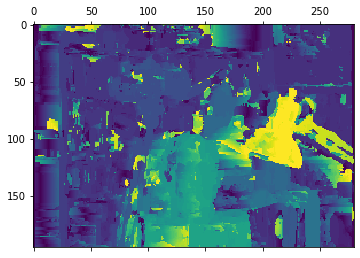

In [4]:
plt.matshow(np.abs(disparity))

Problem 2: Dynamic Programming (50 points)
------------------------------------------

In this problem, implement a dynamic programming based stereo estimation algorithm that incorporates the spatial smoothness between adjacent disparities. For the local matching cost, you can use the same sum-of-squared-differences as above. For the pairwise cost, you can use L1 distance. In your PDF, include both code and the estimated disparity map.

**Hint**: In your algorithms course, you should have covered the Viterbi algorithm. Apply it to this problem. Write out the objective function as a recursive function. As you compute the recurrence, keep track of the pointers to the previous iteration. After you finish the recursive computation, just walk backwards using the stored pointers.

**Hint Two**: To help you debug, you can change the strength of the pairwise term. If you turn off the pairwise term, your implementation should recover the same solution as the greedy approach. If you make the strength of the pairwise term very high, your implementation should assign pixels to be identical disparity.

**Accuracy**: It is OK if you do not get perfect stereo reconstruction. Carl's solution gets it mostly right except for the lamp, which fails due to specular reflection. 

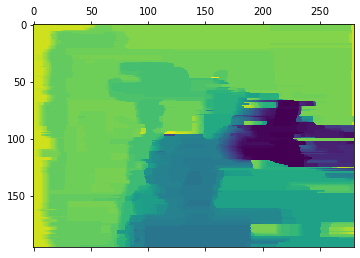

In [21]:
# Some variables that might help you. But you don't have to use them.
# default value win_size = 5
# default max_dx = 30
# for better result: adjusted to win_size = 2, max_dx = 50
max_dx = 50 # max number of displacements to search. make this smaller to speed up
dxs = np.linspace(-max_dx, max_dx, num=2*max_dx+1).astype("int32")

win_size = 2 # size of window you use for ssd computation
lamb_coeff = 1.0 # coefficient in front of pairwise cost

def l1_score(a,b):
    # TODO: implement a score for L1 distance
    #res = sum(abs(a-b))
    res = abs(a-b)
    return res

def compute_disparity_dp():
    # TODO: calculate the disparity using dynamic programming between left and right
    disparity = np.zeros((height,width))
    
    height_pad, width_pad, d = left_pad.shape
       
    for h in range(pad_size,height_pad-pad_size):
        # for each row, compute the shortest path 
        #create a table that store all the cost for each column and disparity
        graph = np.zeros([max_dx*2+1,width])
        # store the previous point
        prev = np.zeros([max_dx*2+1,width], dtype= int)
        for w in range(pad_size,width_pad-pad_size):
            for i in dxs: 
                temp_l = np.zeros([win_size*2+1,win_size*2+1,3])
                temp_r = np.zeros([win_size*2+1,win_size*2+1,3])
                temp_l[:,:,0:3] = left_pad[h-win_size:h+win_size+1, w-win_size:w+win_size+1,0:3]
                temp_r[:,:,0:3] = right_pad[h-win_size:h+win_size+1,i+w-win_size:i+w+win_size+1,0:3]
                ssd = np.sum((temp_l[:,:,0:3]-temp_r[:,:,0:3])**2)
                graph[i+max_dx,w-pad_size] = ssd

        # compute the shortest path of markov chain
        g_height, g_width = graph.shape

        for c in range(1,g_width):
            # the current disparities
            for i in range(g_height):
                min_cost = sys.maxsize
                min_cost_indice = 0
                # the previous disparities
                for j in range(g_height):
                    temp = graph[j,c-1] + lamb_coeff*l1_score(i,j) + graph[i,c]
                    if temp < min_cost:
                        # the previous disparity of the disparity i of c column is prev[i,c]
                        min_cost = temp
                        min_cost_indice = j

                prev[i,c] = min_cost_indice
                graph[i,c] = min_cost


        # the sequence of short path
        # backward process
        path_list = []
        # return the indice of the smallest accumulated cost
        indice = np.argmin(graph[:,width-1])
        path_list.insert(0, indice)    
        count = width -1
        while count > 0:
            prev_indice = prev[indice,count]
            path_list.insert(0, prev_indice) 
            indice = prev_indice
            count = count - 1
        path_list = np.asarray(path_list)
        path_list = path_list - max_dx
        disparity[h-pad_size,:] = path_list
    return disparity[:,:]
disparity2 = compute_disparity_dp()
plt.matshow(disparity2)


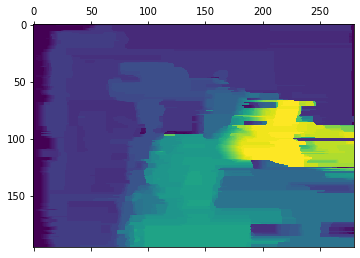

In [22]:
plt.matshow(np.abs(disparity2))


Deliverables
------------

Export your completed notebook as a PDF. Make sure the PDF includes both the code and the resulting output. We will be grading both your code and final output. (Runtime will not impact your score.)